In [10]:
import os,sys,glob,traceback, pickle
import pandas as pd
import xarray as xr
import numpy as np
import scipy
from scipy import stats
from scipy.special import erf
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [16]:
fair_mesmer_run = pd.read_csv('../agriculture/fair_mesmer_run_translation.csv')
scenarios = list(fair_mesmer_run.columns)[1:]
ESMs = [f.split('/')[-1] for f in glob.glob('/mnt/PROVIDE/mesmer_emulations/mesmer-m-tp_emulations/full_emu/netcdf/*')]
gmts = np.arange(0.0, 5., 0.1).round(1)

In [3]:
# match years to gmt bins
selected_years = {}
for scenario in scenarios:
    fair2mesmer = {k:v for k,v in zip(fair_mesmer_run[scenario].values, fair_mesmer_run[scenario].index)}
    mesmer2fair = {v:k for k,v in zip(fair_mesmer_run[scenario].values, fair_mesmer_run[scenario].index)}

    # identify runs that were used for mesmer emulations
    relevant_runs = sorted(fair2mesmer.keys())

    # load gmst trajectories from fair
    gmst = pd.read_csv(f'../agriculture/tier_1/fair_temperatures/scen_{scenario}.csv', index_col=0)
    gmst.columns = [int(c) for c in gmst.columns]

    # select gmst trajectories that correspond to the mesmer emulations
    gmst = gmst.loc[:,relevant_runs]
    gmst.columns = [fair2mesmer[c] for c in gmst.columns]

    # apply 21-year running mean
    gmst = gmst.rolling(window=21, center=True).mean()
    gmst = gmst.iloc[10:-10]
    gmst = gmst.melt(value_vars=gmst.columns, var_name='run', value_name='gmst', ignore_index=False)

    # construct dict of years that match gmst bin in given run
    selected_years[scenario] = {r:{g:list(gmst.loc[(gmst.run == r) & (np.abs(gmst.gmst - g) < 0.05)].index) \
                                    for g in gmts} for r in range(100)}

In [4]:
source = '/mnt/PROVIDE/mesmer-x-processed/regional_averages_realisations'
indicator = 'fwixd'
region = 'PRT'

In [5]:
esms = np.unique([fl.split('_')[-6] for fl in\
     glob.glob(f'{source}/{indicator}/mesmerx_*_*_{indicator}_regional_averages_realisations.nc')])

In [43]:
scens = np.unique([fl.split('_')[-5] for fl in\
     glob.glob(f'{source}/{indicator}/mesmerx_*_*_{indicator}_regional_averages_realisations.nc')])

In [44]:
scens

array(['curpol-os', 'curpol-sap', 'gs', 'gs-nzghg', 'ld', 'ld-nzghg',
       'modact-os-1.5c', 'modact-os-1c', 'modact-sap', 'neg-nzghg',
       'neg-os-0', 'neg-sap', 'ref-1p5-extended', 'ren', 'ren-nzco2',
       'sp', 'sp-nzghg', 'ssp119-extended', 'ssp534-over-extended'],
      dtype='<U20')

In [45]:
scenario_dict = {
    'CurPol' : 'curpol-sap',
    'ModAct' : 'modact-sap',
    'Ren' : 'ren',
    'LD' : 'ld',
    'GS' : 'gs',
    'SP' : 'sp',
    'Neg' : 'neg-os-0',
    'ssp119' : 'ssp119-extended',
    'ssp534-over' : 'ssp534-over-extended',
    'Ref_1p5' : 'ref-1p5-extended',
}

In [46]:
def do_one_scenario(scenario):
    x = np.array([])
    # opend dummy file and construct a gmt mask
    # the mask has the same dimensions as a mesmerX emulation file, but with the gmt in that year instead of the mesmerx value 
    fl = f'{source}/{indicator}/mesmerx_CanESM5_{scenario_dict[scenario]}_{indicator}_regional_averages_realisations.nc'
    y = xr.open_dataset(fl)[indicator].loc[:2100,'PRT']
    mask = y.copy() * np.nan
    for run in range(100):
        years = np.array(selected_years[scenario][run][gmt])
        years = years[years <= 2100]
        mask.loc[years,run,:] = gmt
    # go through esms, open file and store all values corresponding to the gmt (global vriable) in x
    for esm in esms:
        fl = f'{source}/{indicator}/mesmerx_{esm}_{scenario_name_mesmerX}_{indicator}_regional_averages_realisations.nc'
        y = xr.open_dataset(fl)[indicator].loc[:2100,'PRT'].values
        x = np.append(x, y[mask == gmt].flatten())
    # save the values
    np.savetxt(f"../data_mesmer_x_reversal/tmp/{gmt}_{scenario}.csv", x, delimiter=",")  

In [47]:
for gmt in gmts:
    with Pool(10) as p:
        pool_outputs = list(p.map(do_one_scenario, scenario_dict.keys()))

In [ ]:
# construct an array with 100 percentiles for each gmt level
percentiles = xr.DataArray(dims=['gmt','p'], coords=dict(gmt=gmts, p=np.arange(0,101,1,'int')))
for gmt in gmts:
    x = np.array([])
    for scenario in scenario_dict.keys():
        x = np.append(x, np.loadtxt(f"../data_mesmer_x_reversal/tmp/{gmt}_{scenario}.csv", delimiter=","))
    percentiles.loc[gmt][:] = np.percentile(x, range(101))

In [49]:
xr.Dataset({indicator:percentiles}).to_netcdf(f'../data_mesmer_x_reversal/{indicator}.nc')

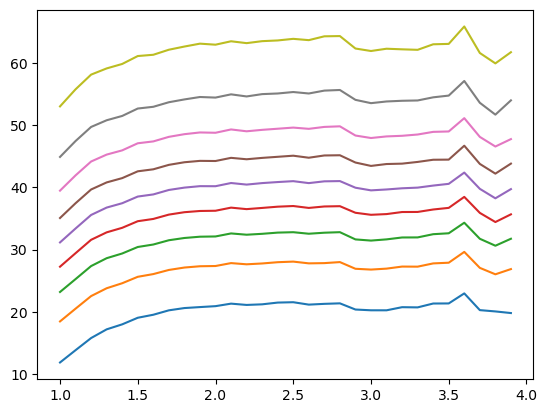

In [50]:
for p in range(10,91,10):
    plt.plot(gmts, percentiles.loc[:,p])

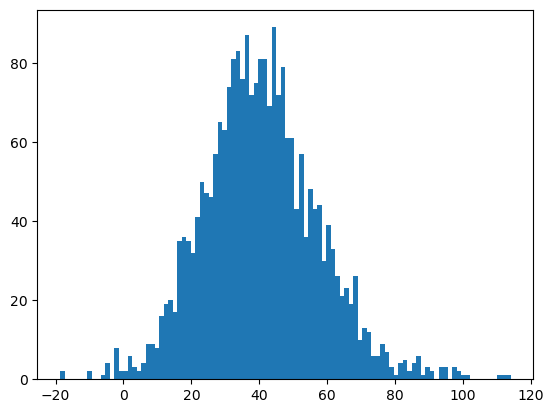

In [51]:
_ = plt.hist(x,bins=100)